In [1]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 3

import xarray as xr
import matplotlib.pyplot as plt

from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.computational_tools import *
from helpers.plot_helpers import *

In [2]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/OM4_SIS2')

Text(0.5, 0.98, 'Filters in ZB20')

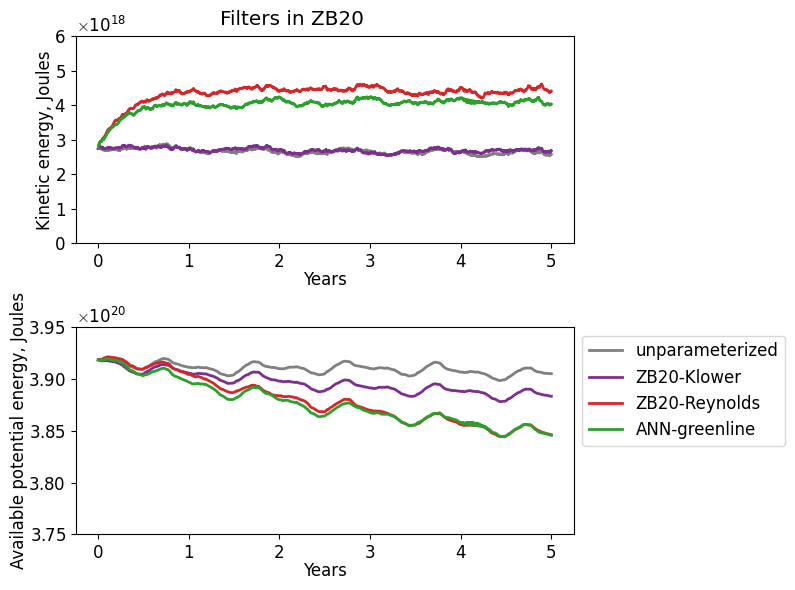

In [3]:
ds.plot_series(['unparameterized', 'ZB20-Klower', 'ZB20-Reynolds', 'ANN-greenline'])
plt.suptitle('Filters in ZB20')

CPU times: user 1.74 s, sys: 509 ms, total: 2.25 s
Wall time: 2.32 s


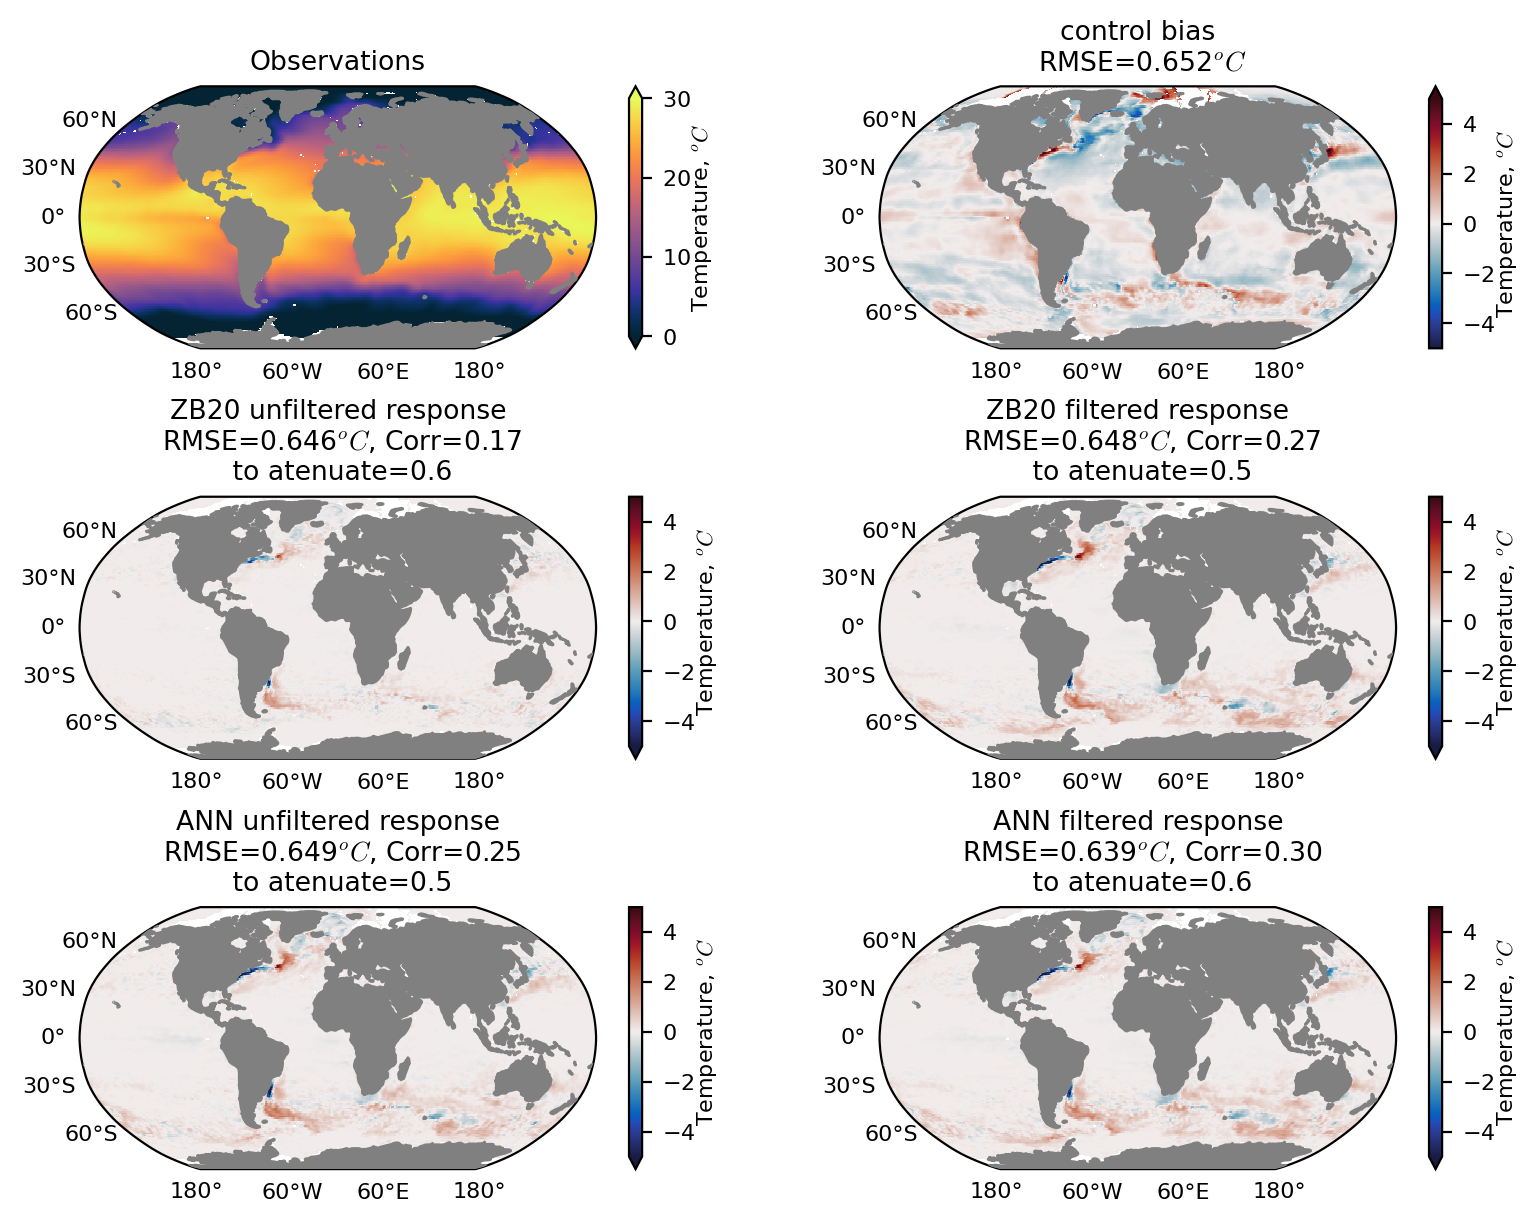

In [34]:
%time ds.plot_temp(['obs', 'unparameterized', 'ZB20-Klower', 'ZB20-Reynolds', 'ANN-greenline', 'ANN-redline'], zl=0, projection='3D', \
                   labels=['Observations', 'control', 'ZB20 unfiltered', 'ZB20 filtered', 'ANN unfiltered', 'ANN filtered'], \
                   plot_type='response')

CPU times: user 277 ms, sys: 12 ms, total: 289 ms
Wall time: 290 ms


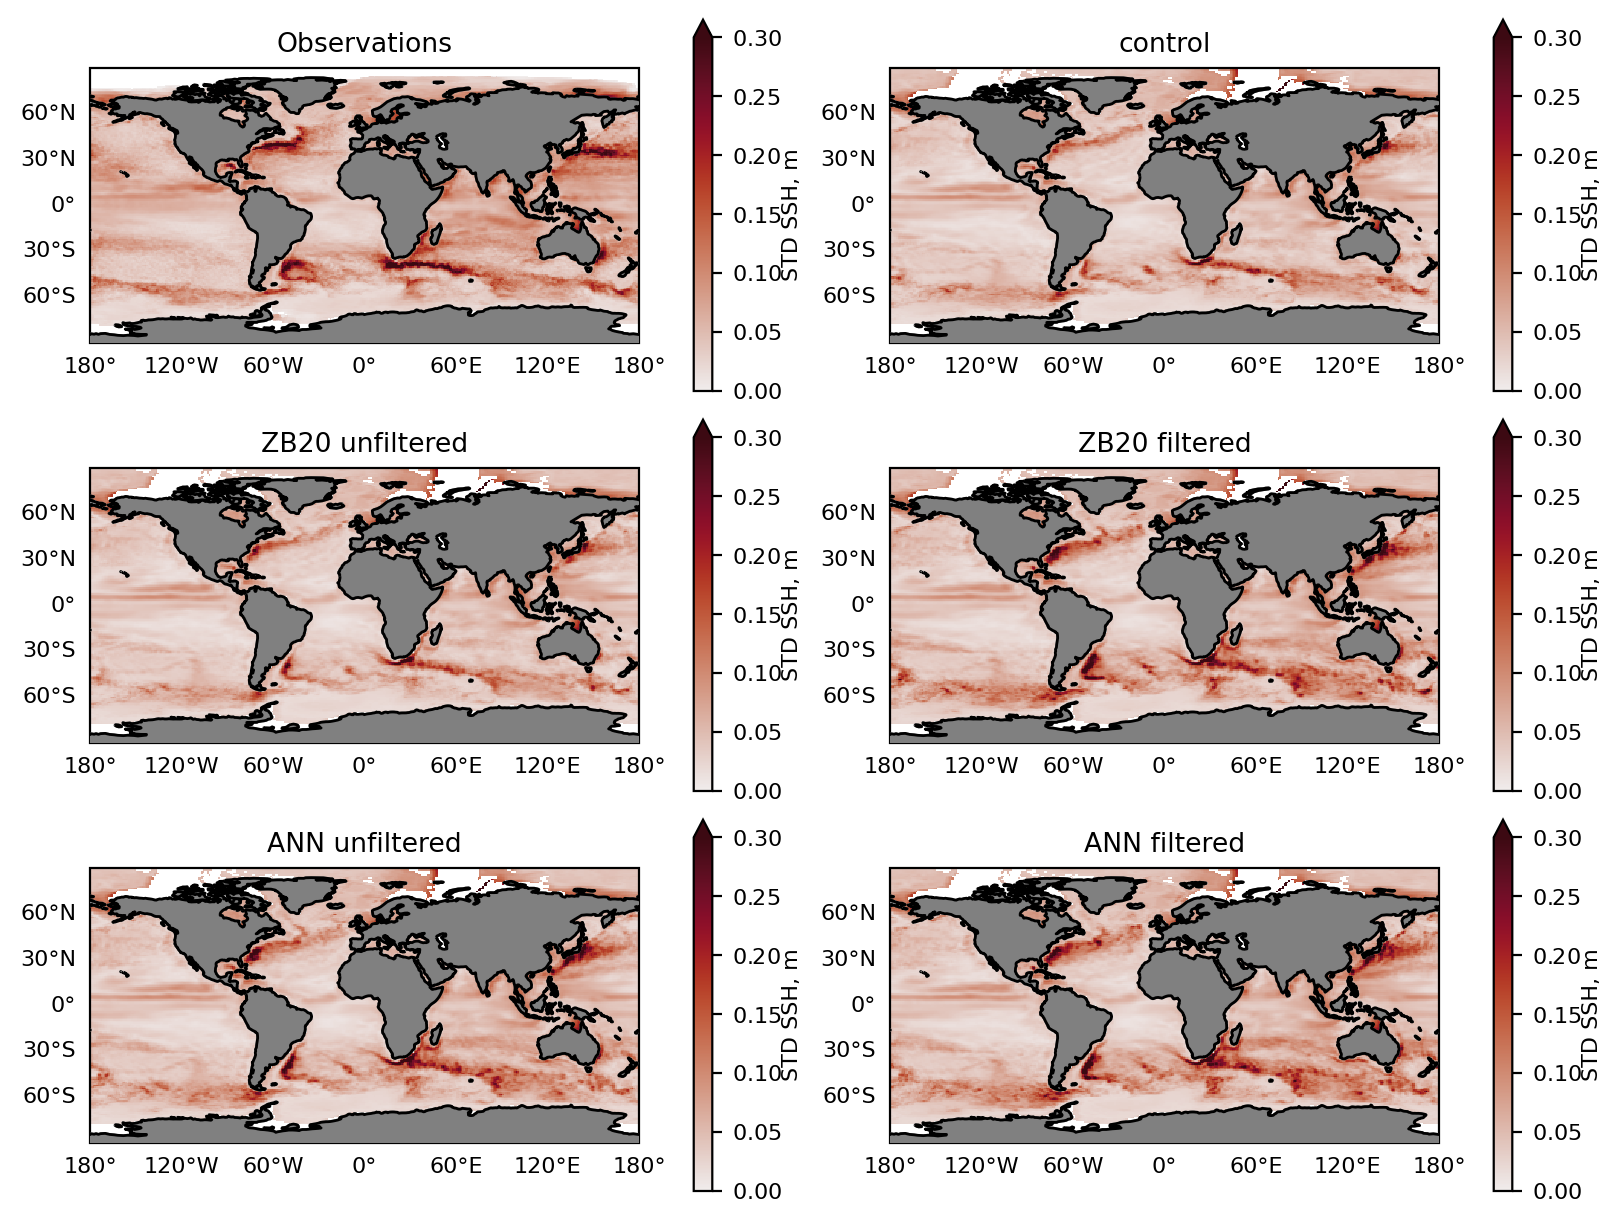

In [114]:
%time ds.plot_ssh_std(['obs', 'unparameterized', 'ZB20-Klower', 'ZB20-Reynolds', 'ANN-greenline', 'ANN-redline'], projection='2D', \
                   labels=['Observations', 'control', 'ZB20 unfiltered', 'ZB20 filtered', 'ANN unfiltered', 'ANN filtered'], \
                   plot_type='default', select=select_globe)

CPU times: user 1.65 s, sys: 342 ms, total: 1.99 s
Wall time: 1.9 s


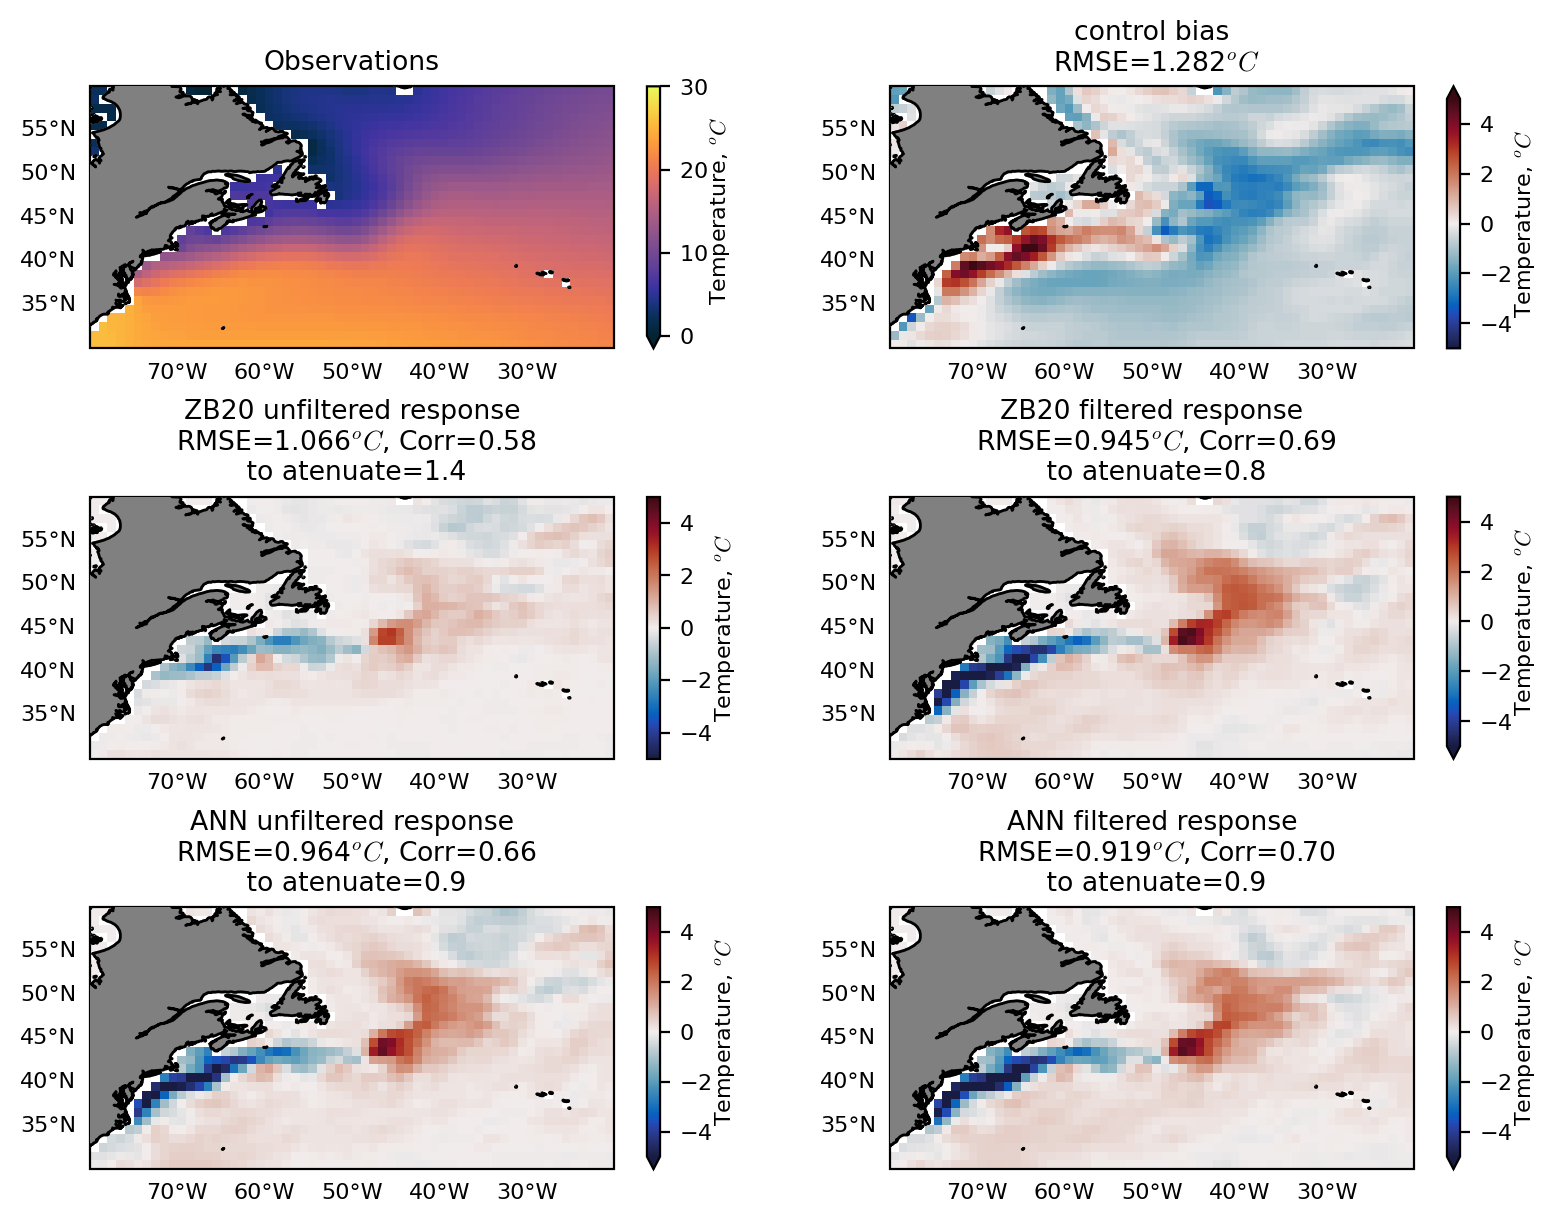

In [43]:
%time ds.plot_temp(['obs', 'unparameterized', 'ZB20-Klower', 'ZB20-Reynolds', 'ANN-greenline', 'ANN-redline'], \
                   select=select_Gulf, \
                   labels=['Observations', 'control', 'ZB20 unfiltered', 'ZB20 filtered', 'ANN unfiltered', 'ANN filtered'], \
                   plot_type='response')

CPU times: user 2.78 s, sys: 719 ms, total: 3.5 s
Wall time: 2.93 s


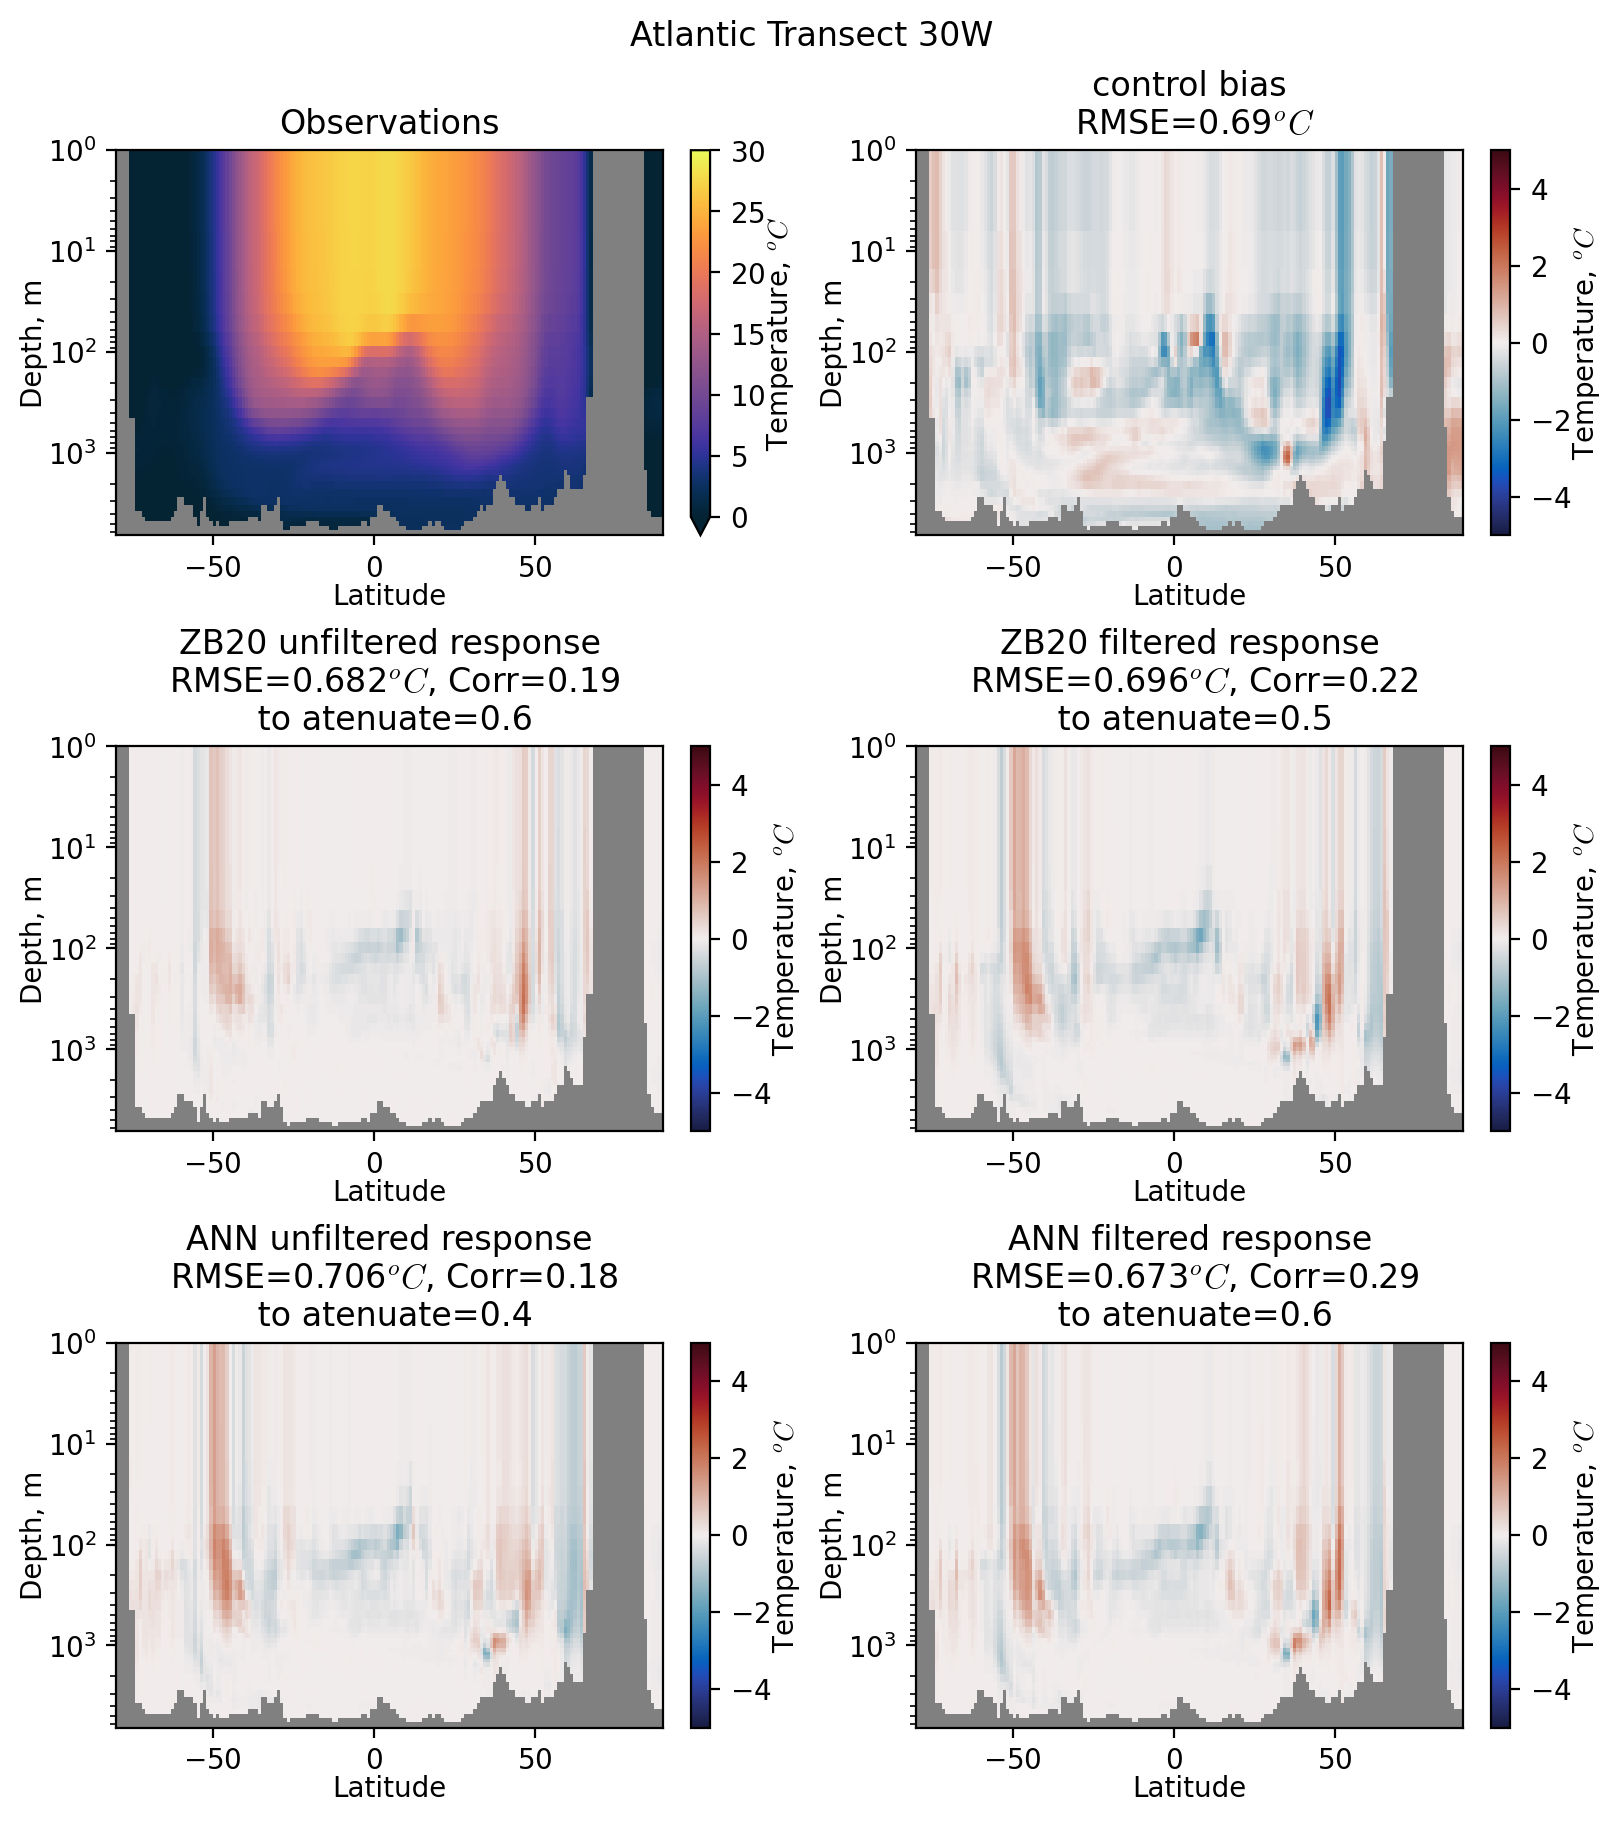

In [51]:
%time ds.plot_temp_section(['obs', 'unparameterized', 'ZB20-Klower', 'ZB20-Reynolds', 'ANN-greenline', 'ANN-redline'], \
                   select=select_Atlantic_transect, \
                   labels=['Observations', 'control', 'ZB20 unfiltered', 'ZB20 filtered', 'ANN unfiltered', 'ANN filtered'], \
                   plot_type='response')
plt.suptitle('Atlantic Transect 30W')
plt.savefig('bias-response-Atlantic.pdf')

CPU times: user 233 ms, sys: 8.88 ms, total: 242 ms
Wall time: 247 ms


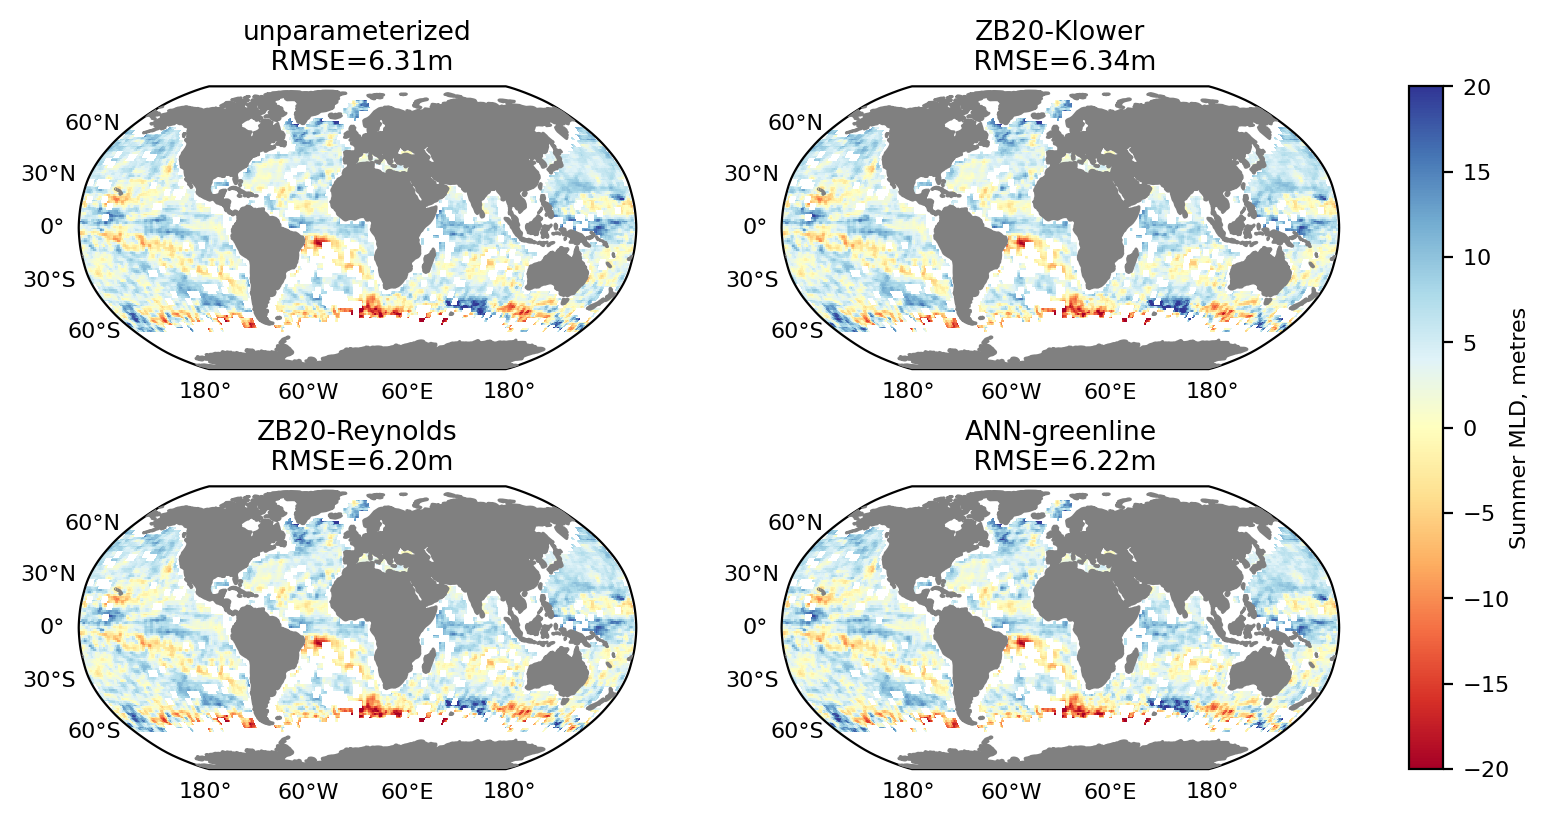

In [69]:
%time ds.plot_MLD_summer(['unparameterized', 'ZB20-Klower', 'ZB20-Reynolds', 'ANN-greenline'], select=select_globe, \
                   plot_type = 'bias', projection='3D')

CPU times: user 5.65 s, sys: 966 ms, total: 6.62 s
Wall time: 7.47 s


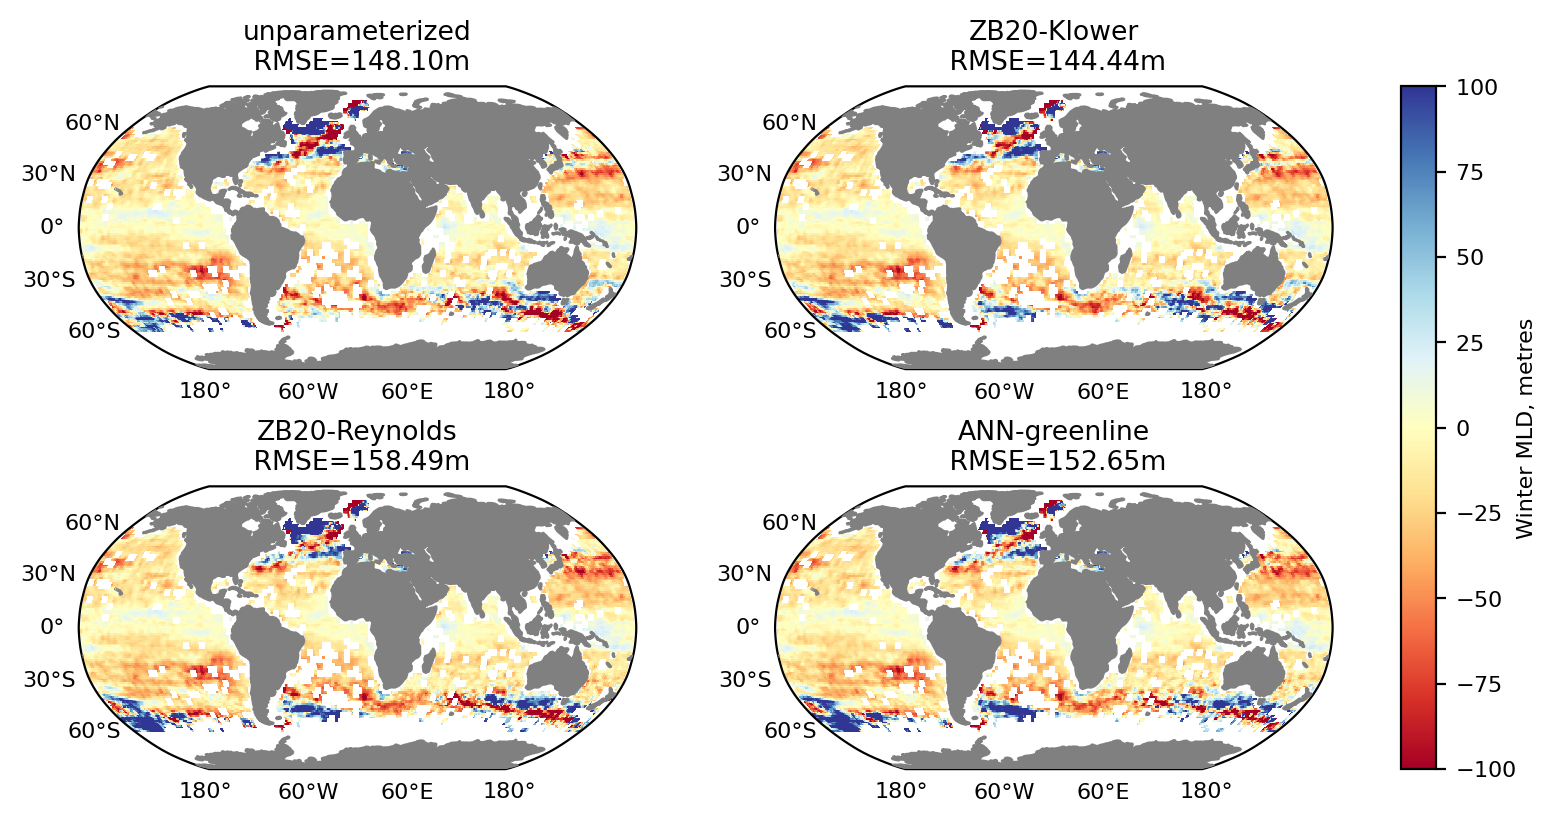

In [70]:
%time ds.plot_MLD_winter(['unparameterized', 'ZB20-Klower', 'ZB20-Reynolds', 'ANN-greenline'], select=select_globe, \
                   plot_type = 'bias', projection='3D')

Correlation: 0.8609298794968778
Relative Error: 0.5848269909665614
R2 =  0.7346356439675155
R2 max =  0.7437806347482859
Optinal scaling: 1.1241284772920777
Nans [test/control]: [62132, 58324]


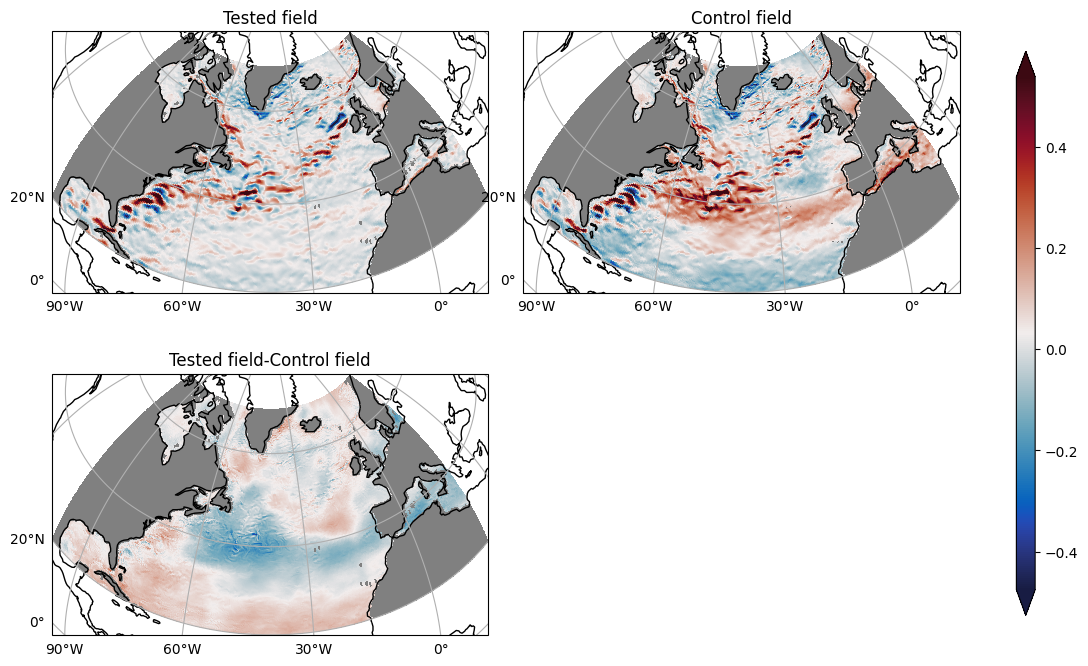

In [36]:
compare(ds['unparameterized'].geoU, ds['unparameterized'].ocean_daily.ssu, selector=select_NA_large)

Correlation: 0.7779230684789438
Relative Error: 0.7212293098723648
R2 =  0.5618397706600747
R2 max =  0.5690604138870234
Optinal scaling: 1.1263245695775244
Nans [test/control]: [43539, 40185]


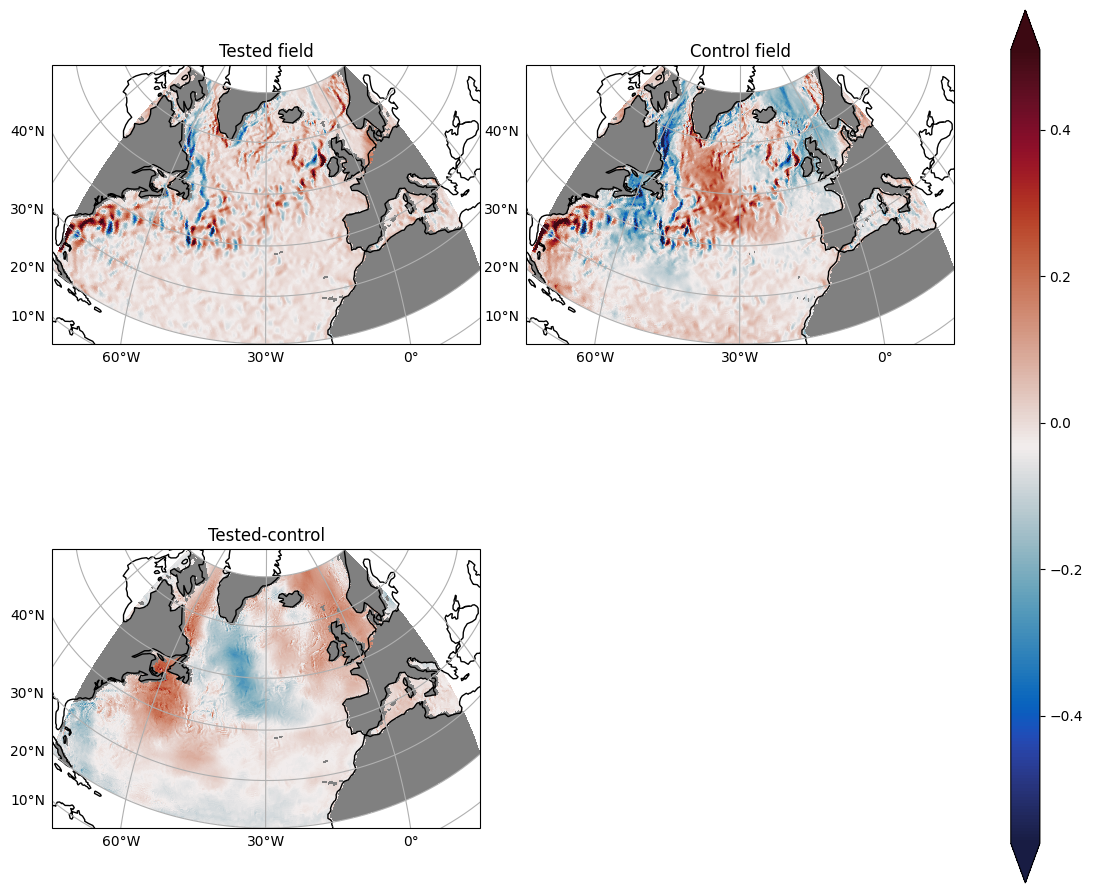

In [98]:
compare(ds['unparameterized'].geoV, ds['unparameterized'].ocean_daily.ssv, selector=select_NA_large)

Correlation: 0.36102482686596993
Relative Error: 1.1563392877578735
R2 =  -0.2913013696670532
R2 max =  0.13043427467346191
Optinal scaling: 0.35737982392311096
Nans [test/control]: [41367, 41367]


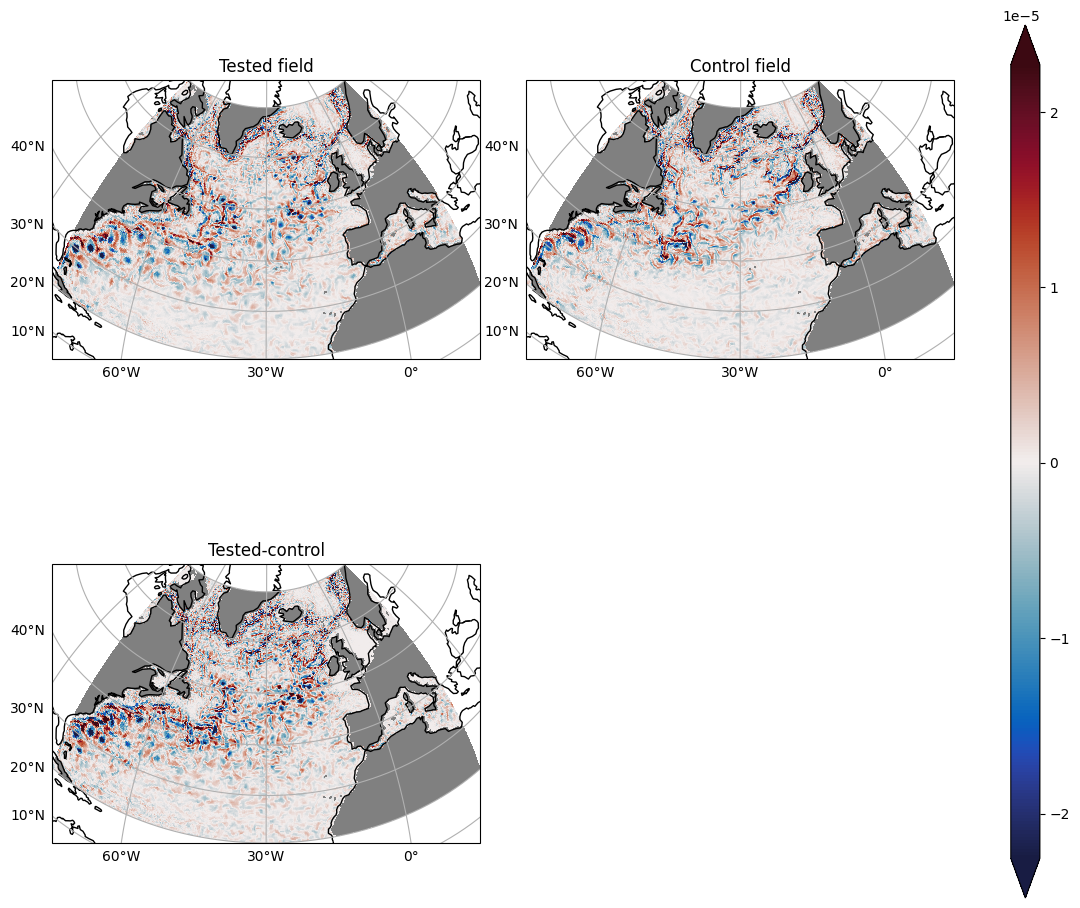

In [169]:
compare(ds['ANN-greenline'].RV, ds['unparameterized'].RV, selector=select_NA_large)

# Regions for Spectrum analysis

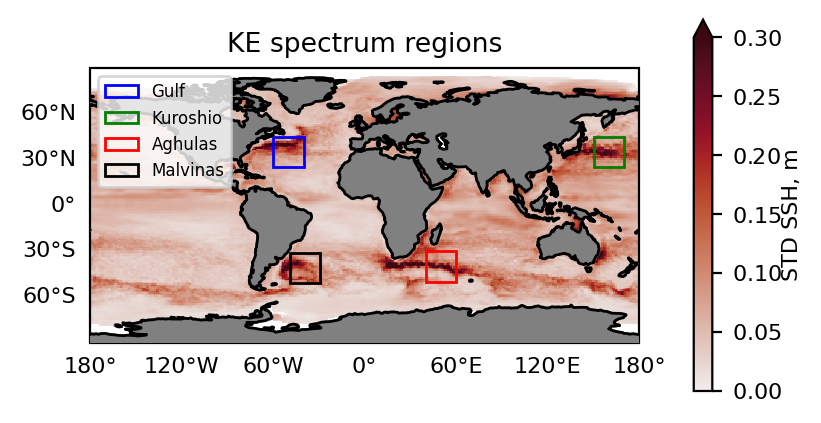

In [353]:
ds.plot_ssh_std(['obs'], ['KE spectrum regions'], select=select_globe)
import matplotlib.patches as patches

rect = patches.Rectangle((-60, 25), 20, 20, linewidth=1, edgecolor='b', facecolor='none', label='Gulf')
plt.gca().add_patch(rect)

rect = patches.Rectangle((150, 25), 20, 20, linewidth=1, edgecolor='g', facecolor='none', label='Kuroshio')
plt.gca().add_patch(rect)

rect = patches.Rectangle((40, -50), 20, 20, linewidth=1, edgecolor='r', facecolor='none', label='Aghulas')
plt.gca().add_patch(rect)

rect = patches.Rectangle((-49, -51), 20, 20, linewidth=1, edgecolor='k', facecolor='none', label='Malvinas')
plt.gca().add_patch(rect)

plt.legend(fontsize=6).set_zorder(1000)
plt.savefig('Spectrum_regions.pdf')

# Computing reference spectra

In [23]:
obs = xr.open_dataset('/vast/pp2681/altimetry_Copernicus.nc', chunks={'time':100}).rename(
            {'longitude': 'xh', 'latitude': 'yh'}).adt.sel(time=slice('1993','1995')).interp({'xh':ds['GM'].param.xh, 'yh':ds['GM'].param.yh},method='linear')

In [24]:
def geoKE_spectrum(zos, Lat=(25,45), Lon=(-60,-40)):
    '''
    We estimate KE spectrum from ssh, i.e.
    it is spectrum of geostrophic motions.
    
    Given the relation u = g/f nabla^perp ssh,
    The KE spectrum is given by:
    KE = g^2 / f^2 * k^2 * E,
    where E is the power spectrum of SSH
    '''
    E = compute_isotropic_PE(zos, ds['GM'].param.dxt, ds['GM'].param.dyt, 
                             Lat=Lat, Lon=Lon)
    Omega = 7.2921e-5
    g = 9.8
    deg_to_rad = np.pi / 180 # degrees to radians factor
    #  Coriolis parameter in the box averaged
    f = 2 * Omega * np.sin(ds['GM'].param.yh * deg_to_rad).sel(yh=slice(Lat[0],Lat[1])).mean()
    
    KE = g**2 / f**2 * E.freq_r**2 * E
    return KE

In [25]:
%time geoKE_Gulf = geoKE_spectrum(obs,Lat=(25,45), Lon=(-60,-40)).mean('time').compute()
geoKE_Gulf.to_netcdf('../data/geoKE_Gulf.nc')

CPU times: user 2min 30s, sys: 1min 6s, total: 3min 37s
Wall time: 39.7 s


In [26]:
%time geoMKE_Gulf = geoKE_spectrum(obs.mean('time'),Lat=(25,45), Lon=(-60,-40)).compute()
geoMKE_Gulf.to_netcdf('../data/geoMKE_Gulf.nc')

CPU times: user 2min 45s, sys: 57.1 s, total: 3min 42s
Wall time: 41.7 s


In [27]:
%time geoKE_Kuroshio = geoKE_spectrum(obs,Lat=(25,45), Lon=(150,170)).mean('time').compute()
geoKE_Kuroshio.to_netcdf('../data/geoKE_Kuroshio.nc')

CPU times: user 2min 29s, sys: 1min 8s, total: 3min 38s
Wall time: 39.8 s


In [28]:
%time geoMKE_Kuroshio = geoKE_spectrum(obs.mean('time'),Lat=(25,45), Lon=(150,170)).compute()
geoMKE_Kuroshio.to_netcdf('../data/geoMKE_Kuroshio.nc')

CPU times: user 2min 45s, sys: 57.2 s, total: 3min 42s
Wall time: 41.9 s


In [29]:
%time geoKE_Aghulas = geoKE_spectrum(obs,Lat=(-50,-30), Lon=(40,60)).mean('time').compute()
geoKE_Aghulas.to_netcdf('../data/geoKE_Aghulas.nc')

CPU times: user 2min 31s, sys: 1min 9s, total: 3min 40s
Wall time: 39.6 s


In [30]:
%time geoMKE_Aghulas = geoKE_spectrum(obs.mean('time'),Lat=(-50,-30), Lon=(40,60)).compute()
geoMKE_Aghulas.to_netcdf('../data/geoMKE_Aghulas.nc')

CPU times: user 2min 45s, sys: 57.2 s, total: 3min 42s
Wall time: 41.8 s


In [31]:
%time geoKE_Malvinas = geoKE_spectrum(obs,Lat=(-51,-31), Lon=(-49,-29)).mean('time').compute()
geoKE_Malvinas.to_netcdf('../data/geoKE_Malvinas.nc')

CPU times: user 2min 30s, sys: 1min 9s, total: 3min 40s
Wall time: 40 s


In [32]:
%time geoMKE_Malvinas = geoKE_spectrum(obs.mean('time'),Lat=(-51,-31), Lon=(-49,-29)).compute()
geoMKE_Malvinas.to_netcdf('../data/geoMKE_Malvinas.nc')

CPU times: user 2min 45s, sys: 57.1 s, total: 3min 42s
Wall time: 41.9 s


In [39]:
geoEKE_Gulf = geoKE_Gulf - geoMKE_Gulf
geoEKE_Kuroshio = geoKE_Kuroshio - geoMKE_Kuroshio
geoEKE_Aghulas = geoKE_Aghulas - geoMKE_Aghulas
geoEKE_Malvinas = geoKE_Malvinas - geoMKE_Malvinas

geoEKE_Kuroshio.to_netcdf('../data/geoEKE_Kuroshio.nc')
geoEKE_Gulf.to_netcdf('../data/geoEKE_Gulf.nc')
geoEKE_Aghulas.to_netcdf('../data/geoEKE_Aghulas.nc')
geoEKE_Malvinas.to_netcdf('../data/geoEKE_Malvinas.nc')

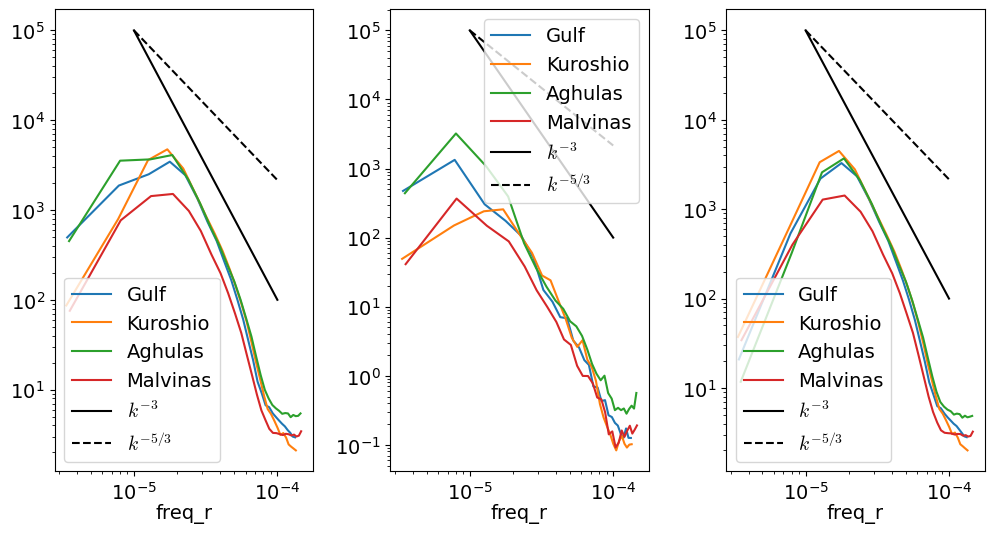

In [37]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)

geoKE_Gulf.plot(label='Gulf')
geoKE_Kuroshio.plot(label='Kuroshio')
geoKE_Aghulas.plot(label='Aghulas')
geoKE_Malvinas.plot(label='Malvinas')


k = np.array([1e-5,1e-4])
plt.plot(k,100000*(k*1e+5)**(-3), color='k', label='$k^{-3}$')
plt.plot(k,100000*(k*1e+5)**(-5./3.), color='k', ls='--', label='$k^{-5/3}$')

plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.subplot(1,3,2)

geoMKE_Gulf.plot(label='Gulf')
geoMKE_Kuroshio.plot(label='Kuroshio')
geoMKE_Aghulas.plot(label='Aghulas')
geoMKE_Malvinas.plot(label='Malvinas')


k = np.array([1e-5,1e-4])
plt.plot(k,100000*(k*1e+5)**(-3), color='k', label='$k^{-3}$')
plt.plot(k,100000*(k*1e+5)**(-5./3.), color='k', ls='--', label='$k^{-5/3}$')

plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.subplot(1,3,3)

geoEKE_Gulf.plot(label='Gulf')
geoEKE_Kuroshio.plot(label='Kuroshio')
geoEKE_Aghulas.plot(label='Aghulas')
geoEKE_Malvinas.plot(label='Malvinas')


k = np.array([1e-5,1e-4])
plt.plot(k,100000*(k*1e+5)**(-3), color='k', label='$k^{-3}$')
plt.plot(k,100000*(k*1e+5)**(-5./3.), color='k', ls='--', label='$k^{-5/3}$')

plt.xscale('log')
plt.yscale('log')
plt.legend()

In [49]:
# ds.plot_KE_spectrum(['unparameterized', 'ZB20-Klower', 'ZB20-Reynolds', 'ANN-greenline', 'ANN-redline', 'JHAH15', 'obs'],
#              labels=['control', 'ZB20 unfiltered', 'ZB20-Reynolds', 'ANN unfiltered', 'ANN filtered', 'JHAH15', 'Observations'],
#              colors=['tab:gray', 'tab:blue', violet, 'tab:green', 'tab:red', 'tab:cyan', 'k'])
# plt.savefig('EKE-spectrum.pdf')

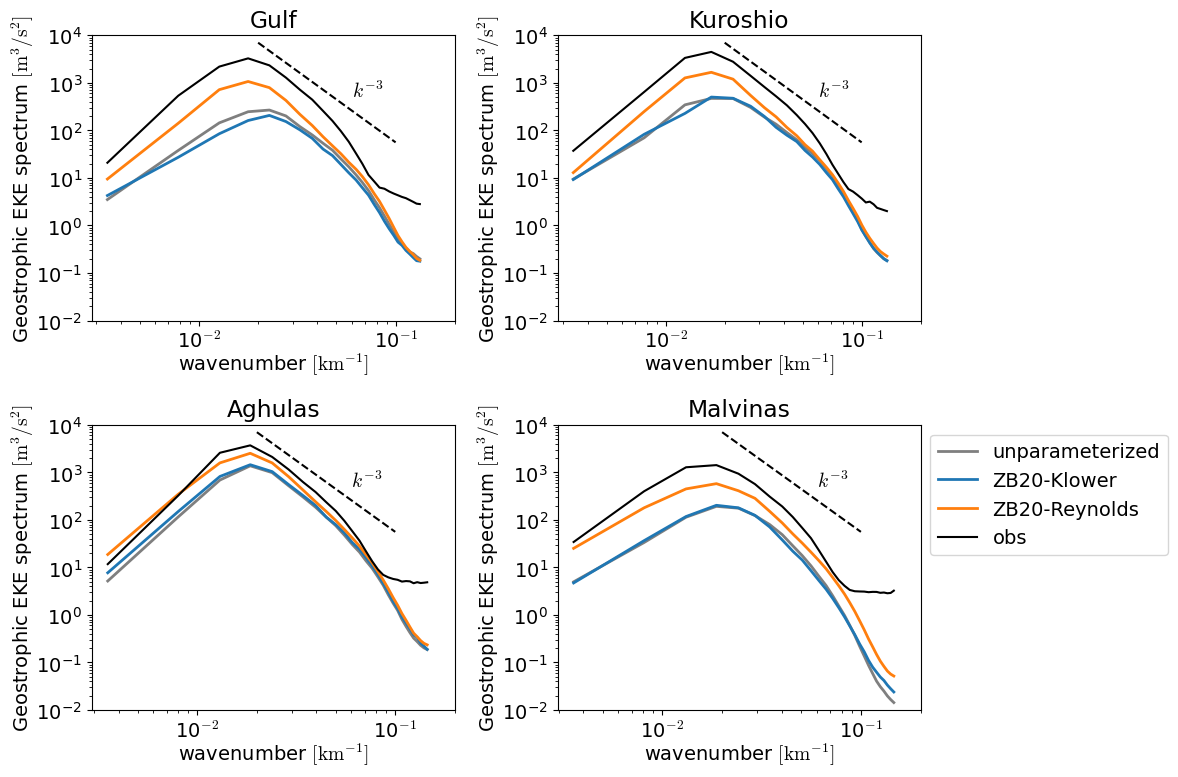

In [44]:
ds.plot_KE_spectrum(['unparameterized', 'ZB20-Klower', 'ZB20-Reynolds', 'obs'])
plt.savefig('EKE-spectrum-2.pdf')

# Geo KE spatial distributions

In [5]:
obs = xr.open_dataset('/vast/pp2681/altimetry_Copernicus.nc', chunks={'time':100}).rename(
            {'longitude': 'xh', 'latitude': 'yh'}).adt.sel(time=slice('1993','1995')).interp({'xh':ds['GM'].param.xh, 'yh':ds['GM'].param.yh},method='linear')

In [6]:
self = ds['GM']
def geoU(zos):
        '''
        u = - g / f * d ssh/dy
        '''
        Omega = 7.2921e-5
        g = 9.8
        deg_to_rad = np.pi / 180 # degrees to radians factor
        fq = 2 * Omega * np.sin(self.param.yq * deg_to_rad)
        grid = create_grid_global(self.param)

        hy = grid.diff(zos, 'Y') / self.param.dyCv
        
        u = grid.interp(- g / fq * hy, 'Y')
        u = xr.where(np.abs(u.yh)<10, np.nan, u)

        return u

def geoV(zos):
    '''
    v = + g / f * d ssh/dx
    '''
    Omega = 7.2921e-5
    g = 9.8
    deg_to_rad = np.pi / 180 # degrees to radians factor
    fh = 2 * Omega * np.sin(self.param.yh * deg_to_rad)
    grid = create_grid_global(self.param)

    hx = grid.diff(zos, 'X') / self.param.dxCu
    
    v = grid.interp(+ g / fh * hx, 'X')
    v = xr.where(np.abs(v.yh)<10, np.nan, v)

    return v

In [8]:
gU = geoU(obs)
gV = geoV(obs)

In [9]:
geoKE_map = ((gU**2 + gV**2) / 2).mean('time').compute()
geoMKE_map = ((gU.mean('time')**2 + gV.mean('time')**2) / 2).compute()
geoEKE_map = geoKE_map - geoMKE_map

In [10]:
geoKE_map.to_netcdf('../data/geoKE_map.nc')
geoMKE_map.to_netcdf('../data/geoMKE_map.nc')
geoEKE_map.to_netcdf('../data/geoEKE_map.nc')

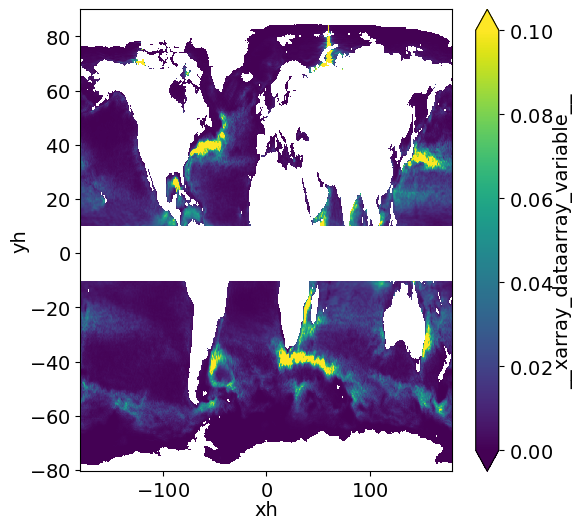

In [75]:
(ds['unparameterized'].geoEKE_map_obs).plot(vmax=0.1,vmin=0)

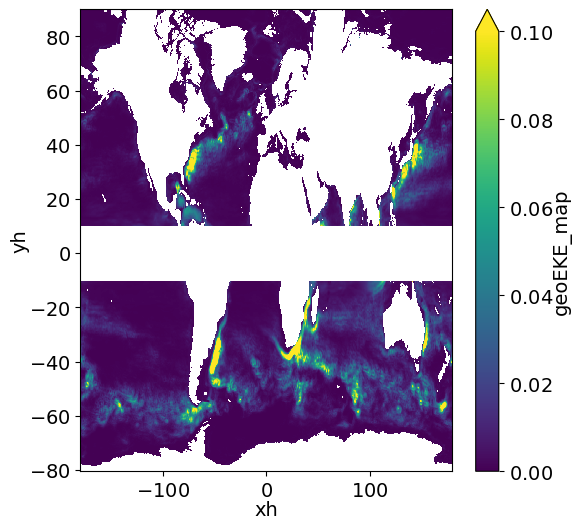

In [76]:
(ds['ZB20-Reynolds'].geoEKE_map).plot(vmax=0.1,vmin=0)

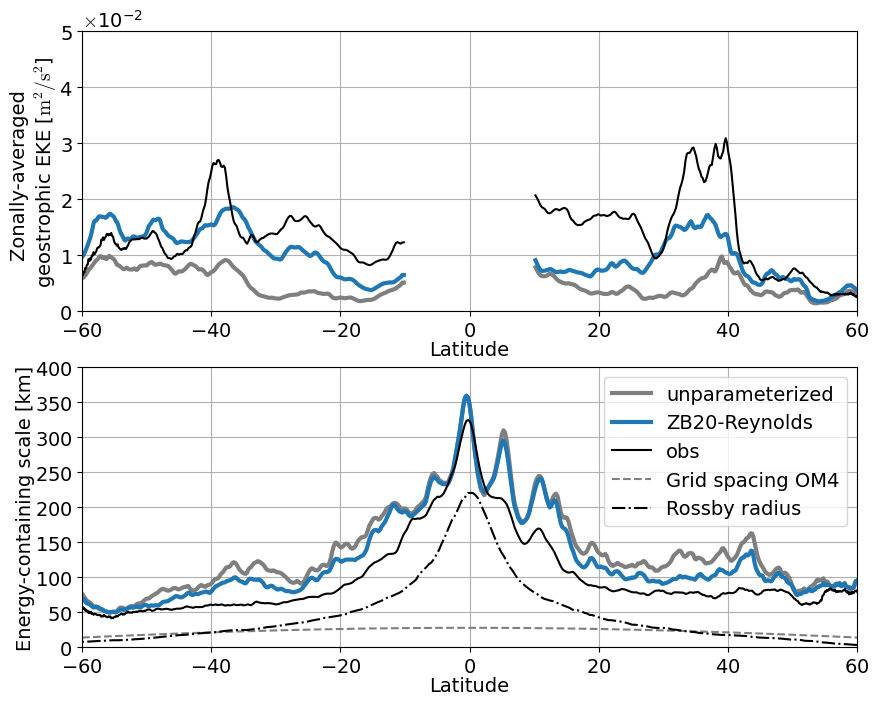

In [154]:
ds.plot_lat(['unparameterized', 'ZB20-Reynolds', 'obs'], type='EKE')

# Length scale

In [97]:
zos = xr.open_dataset('/vast/pp2681/altimetry_Copernicus.nc', chunks={'time':100}).rename(
            {'longitude': 'xh', 'latitude': 'yh'}).adt.sel(time=slice('1993','1995')).interp({'xh':ds['GM'].param.xh, 'yh':ds['GM'].param.yh},method='linear')

In [98]:
# Averaging operator is time mean
mean = lambda x: x.mean(['time'])

zos_anomaly = zos - mean(zos)

zos_anomaly_square = mean((zos_anomaly)**2)

grid = create_grid_global(self.param)
zos_anomaly_x = grid.interp(grid.diff(zos_anomaly, 'X') / self.param.dxCu,'X')
zos_anomaly_y = grid.interp(grid.diff(zos_anomaly, 'Y') / self.param.dyCv,'Y')

zos_grad_anomaly_square = mean( (zos_anomaly_x)**2 + (zos_anomaly_y)**2 )

# in km
eddy_scale = (np.sqrt(zos_anomaly_square / zos_grad_anomaly_square) / 1000.).compute()

In [111]:
eddy_scale.to_netcdf('../data/eddy_scale.nc')

(-60.0, 60.0)

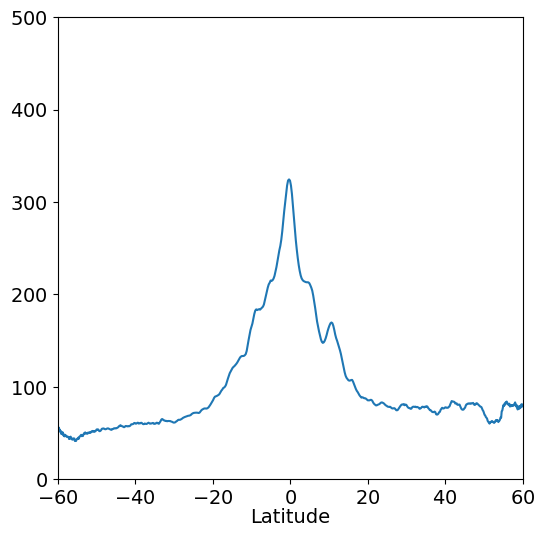

In [106]:
eddy_scale.mean('xh').plot()
plt.ylim([0,500])
plt.xlim([-60,60])

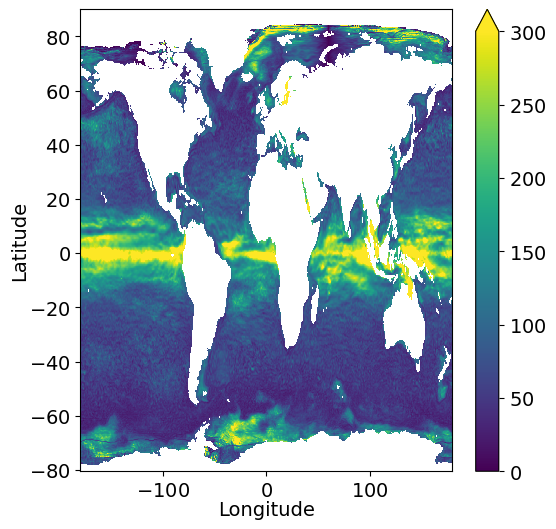

In [110]:
eddy_scale.plot(vmax=300)

(-60.0, 60.0)

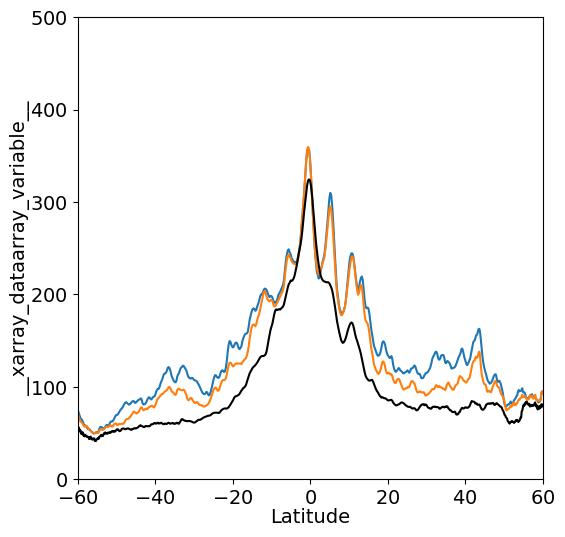

In [137]:
ds['unparameterized'].eddy_scale.mean('xh').plot()
ds['ZB20-Reynolds'].eddy_scale.mean('xh').plot()
ds['unparameterized'].eddy_scale_obs.mean('xh').plot(color='k')
plt.ylim([0,500])
plt.xlim([-60,60])

# GeoVel

In [3]:
obs_raw = xr.open_dataset('/scratch/pp2681/altimetry_Copernicus.nc', chunks={'time':100}).rename(
            {'longitude': 'xh', 'latitude': 'yh'}).adt.sel(time=slice('1993','1995')).isel(time=slice(None,None,3))

obs = obs_raw.interp({'xh':ds['GM'].param.xh, 'yh':ds['GM'].param.yh},method='linear')
obs = xr.where(np.isnan(obs), obs_raw.sel({'xh':ds['GM'].param.xh, 'yh':ds['GM'].param.yh},method='nearest').drop_vars(['xh','yh']), obs)

In [6]:
self = ds['GM']

Omega = 7.2921e-5
g = 9.8
deg_to_rad = np.pi / 180 # degrees to radians factor
fq = 2 * Omega * np.sin(self.param.yq * deg_to_rad)
fh = 2 * Omega * np.sin(self.param.yh * deg_to_rad)
grid = create_grid_global(self.param)

hy = grid.diff(obs, 'Y') / self.param.dyCv

u = grid.interp(- g / fq * hy, 'Y')

u['time'] = obs['time'].copy()

hx = grid.diff(obs, 'X') / self.param.dxCu
        
v = grid.interp(+ g / fh * hx, 'X')

v['time'] = obs['time'].copy()

geovel = np.sqrt(u**2 + v**2)


dyCv = self.param.dyCv
dxCu = self.param.dxCu
IareaBu = 1. / self.param.areacello_bu
dvdx = grid.diff(grid.interp(v,'Y') * dyCv,'X')
dudy = grid.diff(grid.interp(u,'X') * dxCu,'Y')
geoRV = (dvdx - dudy) * IareaBu
geoRV['time'] = obs['time'].copy()

In [46]:
%time geovel.astype('float32').to_netcdf('../data/geovel.nc')

CPU times: user 2min 1s, sys: 29.4 s, total: 2min 30s
Wall time: 5min 6s


In [7]:
geoRV

<xarray.DataArray (yq: 1080, time: 365, xq: 1440)> Size: 5GB
dask.array<mul, shape=(1080, 365, 1440), dtype=float64, chunksize=(720, 34, 1440), chunktype=numpy.ndarray>
Coordinates:
  * xq       (xq) float64 12kB -179.8 -179.5 -179.3 -179.0 ... 179.5 179.7 180.0
  * yq       (yq) float64 9kB -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
  * time     (time) datetime64[ns] 3kB 1993-01-01 1993-01-04 ... 1995-12-29

In [8]:
%time geoRV.astype('float32').to_netcdf('../data/geoRV.nc')

CPU times: user 1min 3s, sys: 42.5 s, total: 1min 46s
Wall time: 22 s


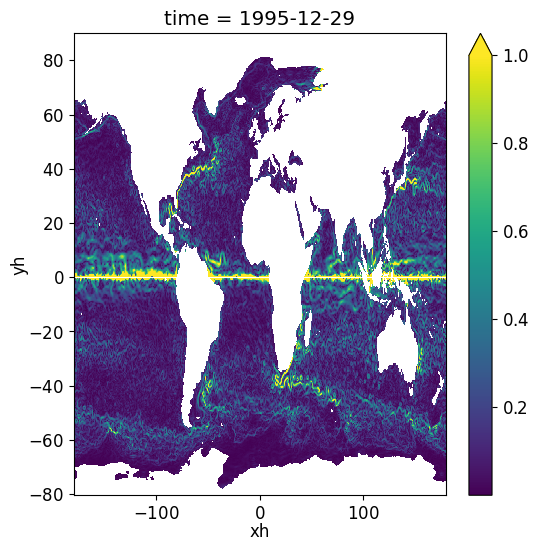

In [44]:
geovel.isel(time=-1).plot(vmax = 1)

# Mean ssh

In [21]:
obs_raw = xr.open_dataset('/scratch/pp2681/altimetry_Copernicus.nc', chunks={'time':100}).rename(
            {'longitude': 'xh', 'latitude': 'yh'}).adt.sel(time=slice('1993', '2012')).mean('time')

obs = obs_raw.interp({'xh':ds['GM'].woa_temp.xh, 'yh':ds['GM'].woa_temp.yh},method='linear')

In [22]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    obs = obs.compute()

[########################################] | 100% Completed | 47.61 s


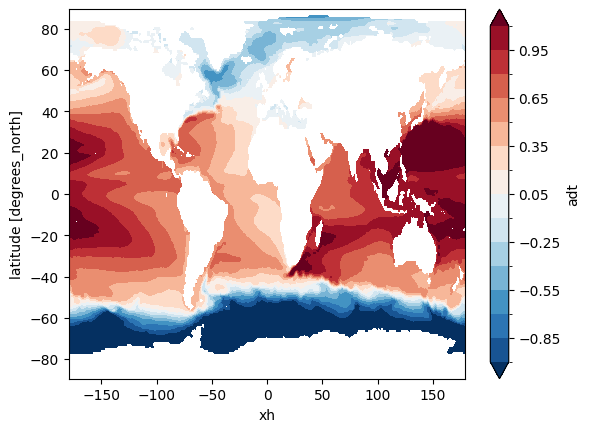

In [29]:
obs.plot.contourf(levels=np.arange(-1.0,1.15,0.15))

In [30]:
obs.astype('float32').to_netcdf('../data/ssh_mean.nc')

In [31]:
obs

<xarray.DataArray 'adt' (yh: 180, xh: 360)> Size: 518kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * xh       (xh) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * yh       (yh) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5

# Vertical structure

In [4]:
ds = xr.open_dataset("gs://cmip6/GFDL_CM2_6/control/ocean_3d", engine='zarr', chunks={}, use_cftime=True)
param = xr.open_dataset('gs://cmip6/GFDL_CM2_6/grid', engine='zarr')

In [5]:
dz = xr.DataArray(np.diff(param.st_edges_ocean), dims=['st_ocean'])

In [6]:
def ave_z(u):
    '''
    Depth-average
    '''
    mask = xr.where(np.isnan(u), np.nan, 1.)

    u_ave = (u * dz).sum('st_ocean') / (mask * dz).sum('st_ocean')
    u_ave = xr.where(np.isnan(u.isel(st_ocean=0)), np.nan, u_ave)
    return u_ave

In [7]:
def ave_x(u):
    '''
    Zonal-average; Here we assume that NaNs are properly defined
    '''
    return u.mean('xu_ocean')

In [95]:
KE = ave_z(0.5*(ds.u**2 + ds.v**2))

In [96]:
KE_BT = 0.5 * (ave_z(ds.u)**2 + ave_z(ds.v)**2)

In [97]:
BT_fraction = KE_BT / KE

In [132]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    frac0 = BT_fraction.isel(time=slice(-73,None)).mean('time').compute()

[########################################] | 100% Completed | 30m 9ss


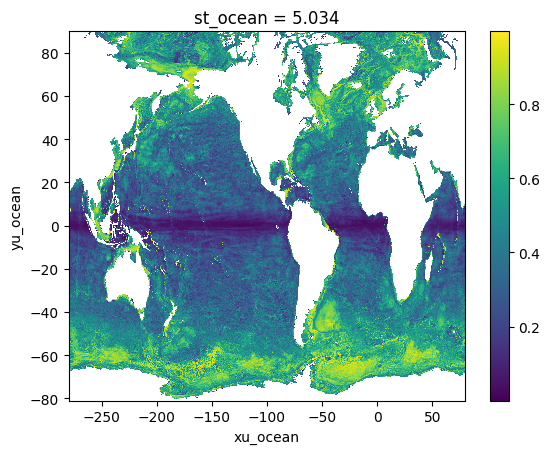

In [134]:
frac0.plot()

(-80.0, 80.0)

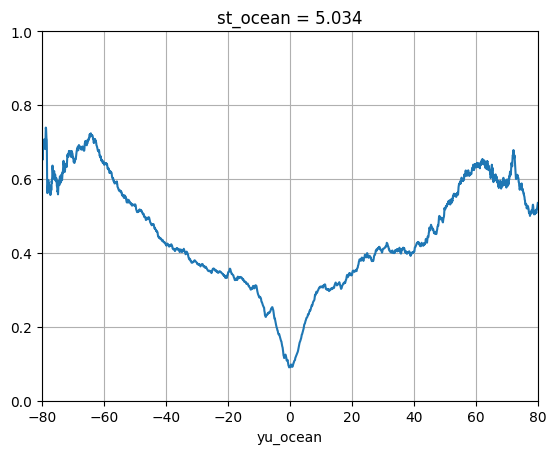

In [139]:
ave_x(frac0).plot()
plt.ylim([0,1])
plt.grid()
plt.xlim([-80,80])

In [140]:
frac0.to_netcdf('../data/BT_fraction_5days.nc')

In [188]:
## Obtain montly averages from 5-day averages

u = ds.u.isel(time=slice(-73,None)).resample(time="M").mean()
v = ds.v.isel(time=slice(-73,None)).resample(time="M").mean()

In [189]:
KE = ave_z(0.5*(u**2 + v**2))

In [190]:
KE_BT = 0.5 * (ave_z(u)**2 + ave_z(v)**2)

In [191]:
BT_fraction = KE_BT / KE

In [193]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    frac1 = BT_fraction.mean('time').compute()

[########################################] | 100% Completed | 17m 17s


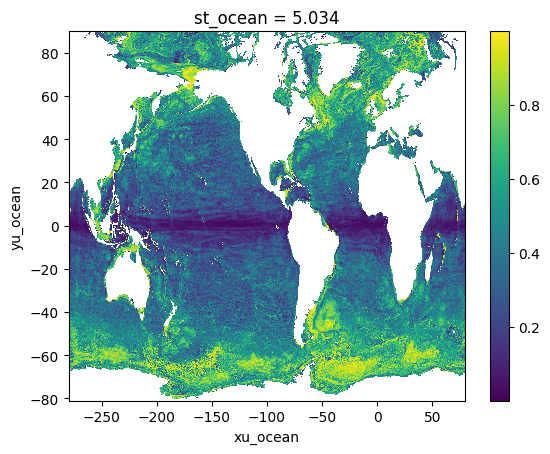

In [195]:
frac1.plot()

Text(0.5, 1.0, '')

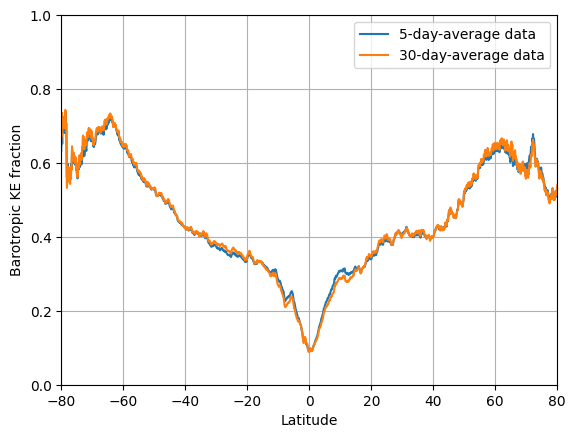

In [199]:
ave_x(frac0).plot(label='5-day-average data')
ave_x(frac1).plot(label='30-day-average data')
plt.ylim([0,1])
plt.grid()
plt.xlim([-80,80])
plt.legend()
plt.ylabel('Barotropic KE fraction')
plt.xlabel('Latitude')
plt.title('')

In [200]:
frac1.to_netcdf('../data/BT_fraction_30days.nc')

In [8]:
## Obtain montly averages on 0.3 degree grid from 5-day averages

u = ds.u.isel(time=slice(-73,None)).resample(time="M").mean().coarsen({'xu_ocean':3, 'yu_ocean':3}).mean()
v = ds.v.isel(time=slice(-73,None)).resample(time="M").mean().coarsen({'xu_ocean':3, 'yu_ocean':3}).mean()

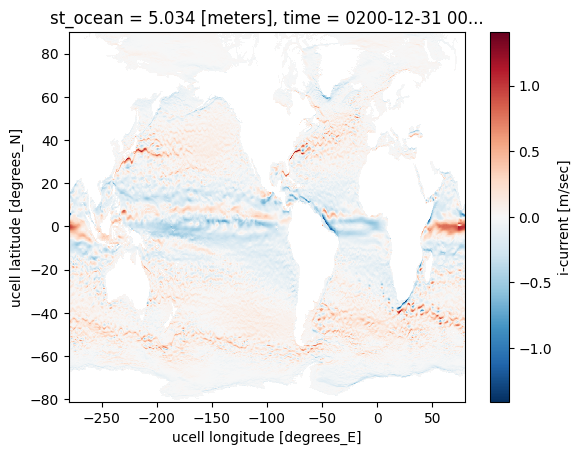

In [6]:
u.isel(time=-1, st_ocean=0).plot()

In [39]:
KE_3d = 0.5 * (u**2 + v**2)

In [40]:
KE = ave_z(KE_3d)

In [10]:
ubar = ave_z(u)

In [42]:
vbar = ave_z(v)

In [43]:
KE_BT = 0.5 * (ubar**2 + vbar**2)

In [44]:
BT_fraction = KE_BT / KE

In [219]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    frac2 = BT_fraction.mean('time').compute()

[########################################] | 100% Completed | 13m 37s


In [45]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    KE0 = KE.mean('time').compute()
    KE_BT0 = KE_BT.mean('time').compute()

[###                                     ] | 9% Completed | 92.48 sms

/ext3/miniconda3/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 17m 13s
[###                                     ] | 9% Completed | 84.69 sms

/ext3/miniconda3/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 14m 38s


In [11]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    ubar0 = ubar.mean('time').compute()

[########################################] | 100% Completed | 291.43 s


In [12]:
ubar0.to_netcdf('../data/ubar.nc')

In [46]:
KE0.to_netcdf('../data/KE.nc')
KE_BT0.to_netcdf('../data/KE_BT.nc')

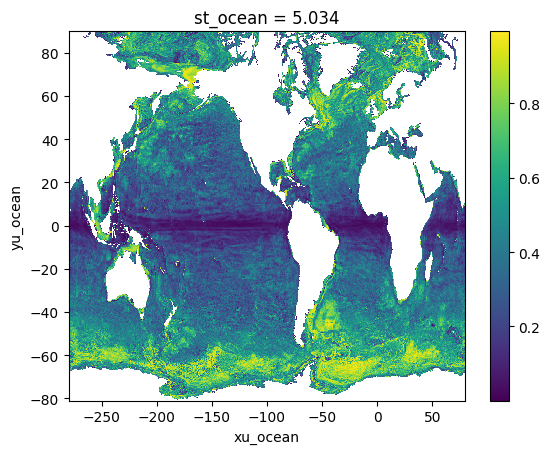

In [220]:
frac2.plot()

Text(0.5, 1.0, '')

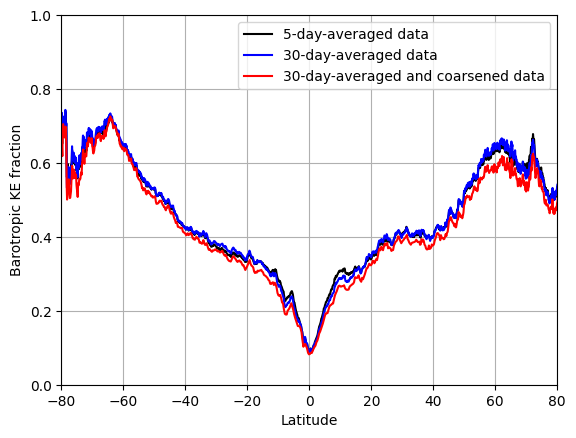

In [222]:
ave_x(frac0).plot(label='5-day-averaged data', color='k')
ave_x(frac1).plot(label='30-day-averaged data', color='b')
ave_x(frac2).plot(label='30-day-averaged and coarsened data', color='r')
plt.ylim([0,1])
plt.grid()
plt.xlim([-80,80])
plt.legend()
plt.ylabel('Barotropic KE fraction')
plt.xlabel('Latitude')
plt.title('')

In [223]:
frac2.to_netcdf('../data/BT_fraction_30days_coarsen.nc')

# Compare to simulation data

Text(0.5, 1.0, '')

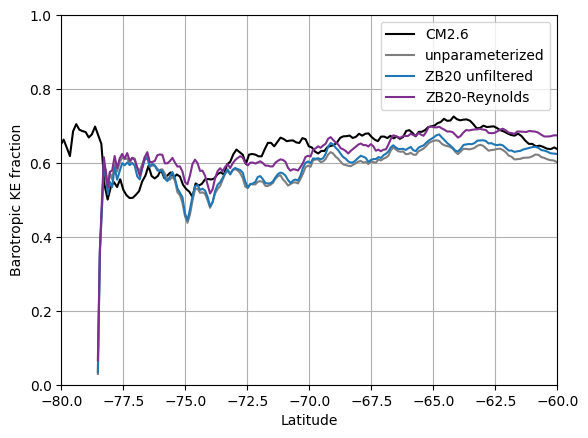

In [22]:
(ds['unparameterized'].BT_fraction_obs).mean('xu_ocean').plot(color='k', label='CM2.6')
(ds['unparameterized'].BT_fraction).mean('xh').plot(color='tab:gray', label='unparameterized')
(ds['ZB20-Klower'].BT_fraction).mean('xh').plot(color='tab:blue', label='ZB20 unfiltered')
(ds['ZB20-Reynolds'].BT_fraction).mean('xh').plot(color=violet, label='ZB20-Reynolds')
plt.ylim([0,1])
plt.grid()
plt.xlim([-80,-60])
plt.legend()
plt.ylabel('Barotropic KE fraction')
plt.xlabel('Latitude')
plt.title('')

Text(0.5, 1.0, '')

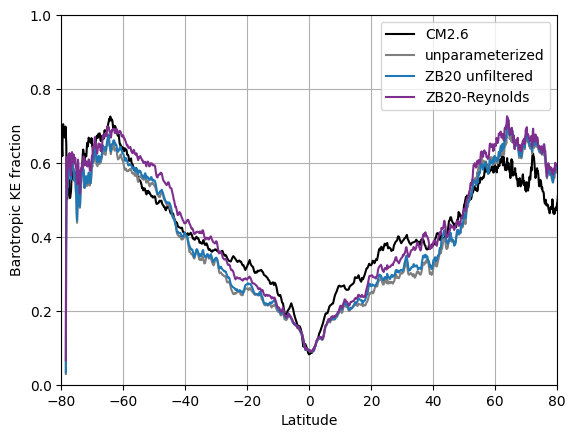

In [23]:
(ds['unparameterized'].BT_fraction_obs).mean('xu_ocean').plot(color='k', label='CM2.6')
(ds['unparameterized'].BT_fraction).mean('xh').plot(color='tab:gray', label='unparameterized')
(ds['ZB20-Klower'].BT_fraction).mean('xh').plot(color='tab:blue', label='ZB20 unfiltered')
(ds['ZB20-Reynolds'].BT_fraction).mean('xh').plot(color=violet, label='ZB20-Reynolds')
plt.ylim([0,1])
plt.grid()
plt.xlim([-80,80])
plt.legend()
plt.ylabel('Barotropic KE fraction')
plt.xlabel('Latitude')
plt.title('')